# Build and train A Generative Adversarial Network

In this notebook you'll find the entire code presented in the previous lessons. We once again use our beloved CIFAR10 dataset.

We define a Generator and a Discriminator network, whic consist only of `Linear` and `Relu` layers.`Dropout` is also use to prevent overfitting. We then train them both using the process we described in the lesson. 

Feel free to play around, execute a few epochs and make sure that you understand everything you learned in this chapter.

You can also try to alternate the network by adding more layers. Try adding a supervised pixel-wise loss (`torch.nn.L1Loss`) in the generator's output and Notice if the performance gets better. Are the images more realistic? What is the relationship between L1 loss and adversarial loss optimization? What are the best scalar terms to balance the two losses?


In [1]:
# Numpy is linear algebra lbrary
import numpy as np
# Matplotlib is a visualizations library 
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import utils
from torchvision import transforms
import torchvision.utils as vutils

/home/kaushik/miniconda3/envs/py3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the flag whether you want to run the execute locally or on the course's website.

In [2]:
flag_local_run = True

In [3]:
if flag_local_run:
    from torchvision.datasets import CIFAR10
else:
    import os
    import sys
    cwd = os.getcwd()
    #add CIFAR10 data in the environment
    sys.path.append(cwd + '/../cifar10')

    #CIFAR10 is a custom Dataloader that loads a subset ofthe data from a local folder
    from Cifar10Dataloader import CIFAR10

In [4]:
# Set the dataset path
if flag_local_run:
    dataset_path = '~/data/cifar10'
else:
    dataset_path = '../cifar10'

In [5]:
batch_size=4

def load_data():
    
    #convert the images to tensor and normalized them
    transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    trainset = CIFAR10(root=dataset_path,  transform=transform)  # root='../cifar10'
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=False, num_workers=1)
    return trainloader


## Utility functions


In [6]:

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 32, 32)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def log_images(images, num_images, format='NCHW', normalize=True):
    '''
    input images are expected in format (NCHW)
    '''
    if type(images) == np.ndarray:
        images = torch.from_numpy(images)

    if format == 'NHWC':
        images = images.transpose(1, 3)

    # Make horizontal grid from image tensor
    horizontal_grid = vutils.make_grid(
        images, normalize=normalize, scale_each=True)
    # Make vertical grid from image tensor
    nrows = int(np.sqrt(num_images))
    grid = vutils.make_grid(
        images, nrow=nrows, normalize=True, scale_each=True)
    
    fig = plt.figure(figsize=(16, 16))
    plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
    plt.axis('off')
    # display(plt.gcf())
    # if plot_horizontal:
    #    display.display(plt.gcf())
    plt.show()

## Generator and Discriminator 

In [7]:

class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """

    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 3072
        n_out = 1

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """

    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 3072

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

## Train a GAN

* Note 1: You can use the `log_images` function to plot the generated images.
* Note 2: The training process is quite slow so I wouldn't expect to reach high levels of accuracy, because the notebook will remain open only for 15 mins. 

Epoch: [0/5], Batch Num: [0/12500]
Discriminator Loss: 1.3879, Generator Loss: 0.6734
D(x): 0.5132, D(G(z)): 0.5136, std(D(x)): 0.0050, std(D(G(z))): 0.0006
------------------------------
Epoch: [0/5], Batch Num: [50/12500]
Discriminator Loss: 0.4691, Generator Loss: 2.0355
D(x): 0.8461, D(G(z)): 0.2349, std(D(x)): 0.2220, std(D(G(z))): 0.0693
------------------------------
Epoch: [0/5], Batch Num: [100/12500]
Discriminator Loss: 0.3249, Generator Loss: 1.4377
D(x): 0.9984, D(G(z)): 0.2757, std(D(x)): 0.0032, std(D(G(z))): 0.0336
------------------------------
Epoch: [0/5], Batch Num: [150/12500]
Discriminator Loss: 0.6041, Generator Loss: 0.9506
D(x): 0.9018, D(G(z)): 0.3866, std(D(x)): 0.1470, std(D(G(z))): 0.0283
------------------------------
Epoch: [0/5], Batch Num: [200/12500]
Discriminator Loss: 0.4879, Generator Loss: 1.2696
D(x): 0.8994, D(G(z)): 0.3039, std(D(x)): 0.1621, std(D(G(z))): 0.0827
------------------------------
Epoch: [0/5], Batch Num: [250/12500]
Discriminator Lo

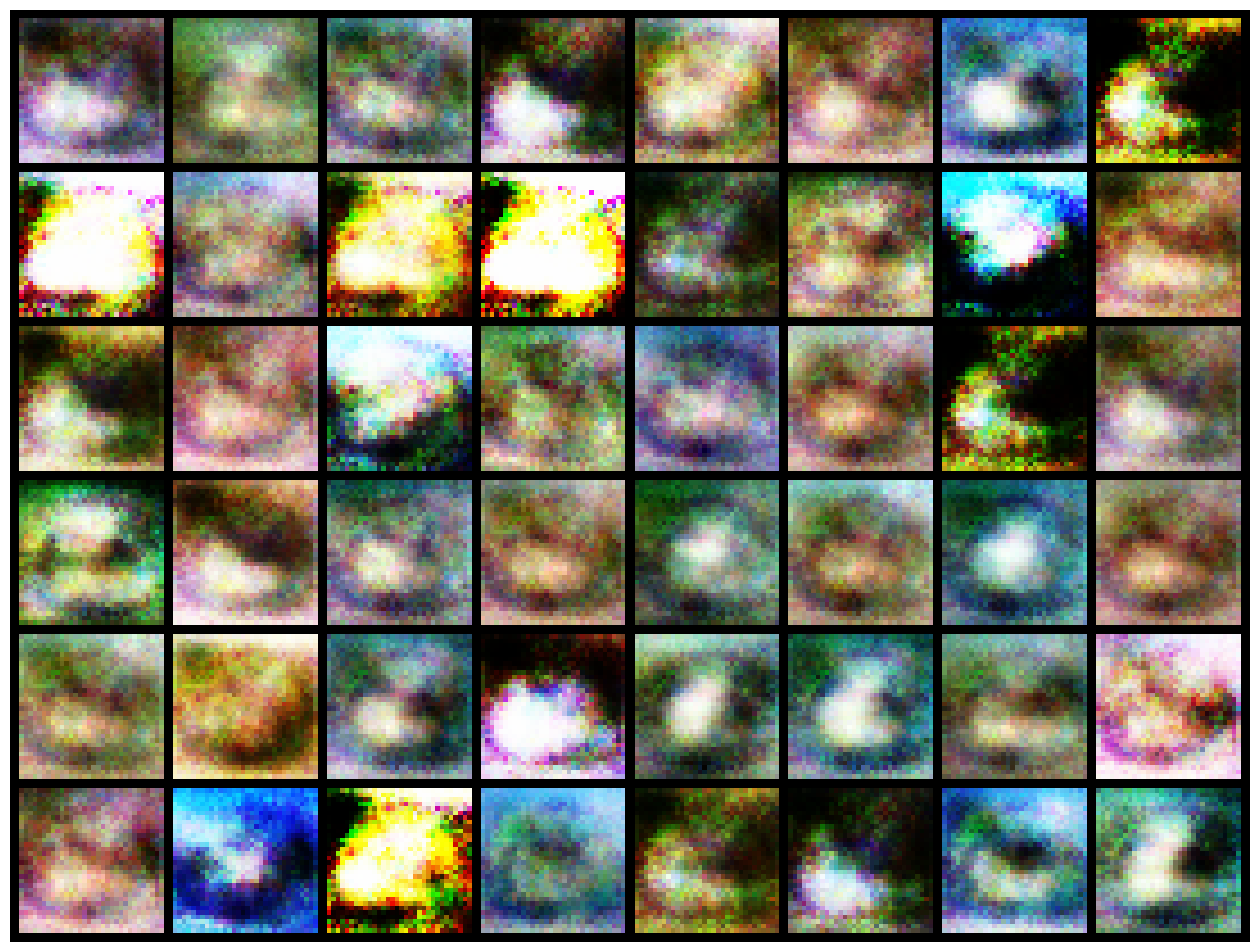

In [8]:
def train_discriminator(discriminator, optimizer, real_data, fake_data, loss):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()

    # Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, Variable(torch.ones(N, 1)))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, Variable(torch.zeros(N, 1)))
    error_fake.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(discriminator, optimizer, fake_data, loss): 
    # Reset gradients
    N = fake_data.size(0)  
    
    # Sample noise and generate fake data
    optimizer.zero_grad()  
    
    # Calculate error and backpropagate
    prediction = discriminator(fake_data)  
    error = loss(prediction, Variable(torch.ones(N, 1)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()  
    
    # Return error
    return error


def train():

    # Models, optimizers and losses
    discriminator = DiscriminatorNet()
    generator = GeneratorNet()
    loss_d = nn.BCELoss()
    loss_g = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), 0.0002)
    g_optimizer = optim.Adam(generator.parameters(), 0.0002)

    data_loader = load_data()
    
    num_epochs = 5
    num_batches = len(data_loader)
    
    num_test_samples = 48
    test_noise = noise(num_test_samples)


    for epoch in range(num_epochs):
        for n_batch, data in enumerate(data_loader):

            (real_batch, labels) = data
            N = real_batch.size(0)

            # 1. Train Discriminator
            real_data = real_batch.view(real_batch.size(0), -1)

            # Generate fake data and detach so gradients are not calculated for generator)
            latent_space_data = noise(N)
            fake_data = generator(latent_space_data).detach()

            d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator, d_optimizer, real_data,
                                                                          fake_data,
                                                                          loss_d)
            # 2. Train Generator

            # Generate fake data TO train Generator
            latent_space_data = noise(N)
            fake_data = generator(latent_space_data)
            # Train G
            g_error = train_generator(discriminator, g_optimizer, fake_data, loss_g)  # Log batch error

            
            if n_batch % 50 == 0:
                print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
                            epoch, num_epochs, n_batch, num_batches)
                    )
                print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
                print('D(x): {:.4f}, D(G(z)): {:.4f}, std(D(x)): {:.4f}, std(D(G(z))): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean(), d_pred_real.std(), d_pred_fake.std()))
                print('------------------------------')
                
              
    
    print('Training finished')
    
    #Generate images
    test_images = vectors_to_images(generator(test_noise))
    test_images = test_images.data
    log_images(test_images,test_images.size()[0])
    
train()
